In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')

# 1. Data Preprocessing
# Handle categorical variables
binary_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
ordinal_cols = ['CAEC', 'CALC']
nominal_cols = ['MTRANS']

In [10]:
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# Ordinal encoding
caec_mapping = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
calc_mapping = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
df['CAEC'] = df['CAEC'].map(caec_mapping)
df['CALC'] = df['CALC'].map(calc_mapping)

In [12]:
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

# Feature Engineering: Calculate BMI
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# 2. Outlier Detection & Handling
def handle_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = df[col].quantile(0.05)
    upper_bound = df[col].quantile(0.95)
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

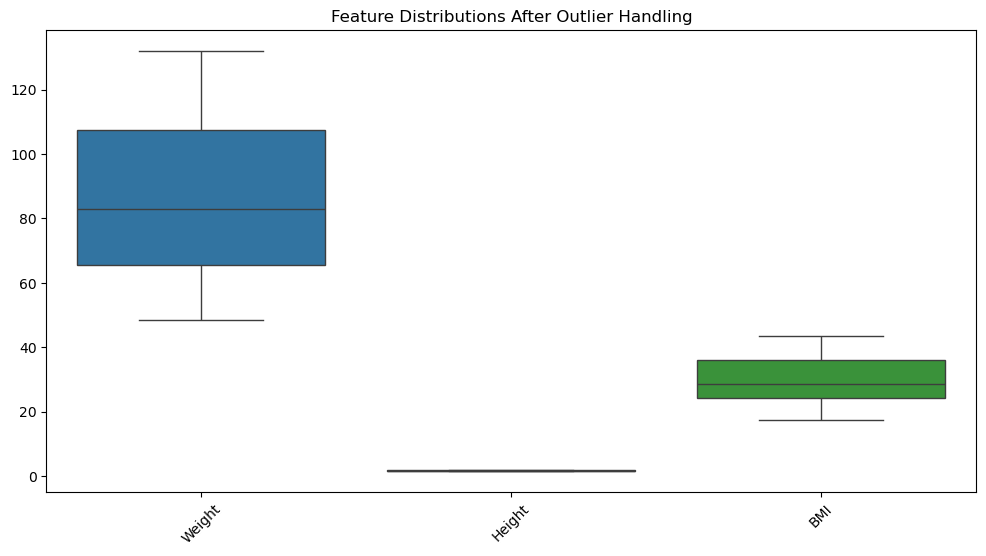

In [14]:
num_cols = ['Age', 'Height', 'Weight', 'NCP', 'CH2O', 'FAF', 'TUE']
for col in num_cols + ['BMI']:
    df = handle_outliers(df, col)

# Visualize outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Weight', 'Height', 'BMI']])
plt.title('Feature Distributions After Outlier Handling')
plt.xticks(rotation=45)
plt.show()

In [16]:
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Label encode target
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Model Training (XGBoost)
params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [18]:
xgb = XGBClassifier(objective='multi:softmax', random_state=42)
grid = GridSearchCV(xgb, params, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# 5. Evaluation
print(f"Best Parameters: {grid.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le_y.classes_))

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.9882

Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight       1.00      0.96      0.98        56
      Normal_Weight       0.94      1.00      0.97        62
     Obesity_Type_I       1.00      1.00      1.00        78
    Obesity_Type_II       1.00      1.00      1.00        58
   Obesity_Type_III       1.00      1.00      1.00        63
 Overweight_Level_I       1.00      0.95      0.97        56
Overweight_Level_II       0.98      1.00      0.99        50

           accuracy                           0.99       423
          macro avg       0.99      0.99      0.99       423
       weighted avg       0.99      0.99      0.99       423



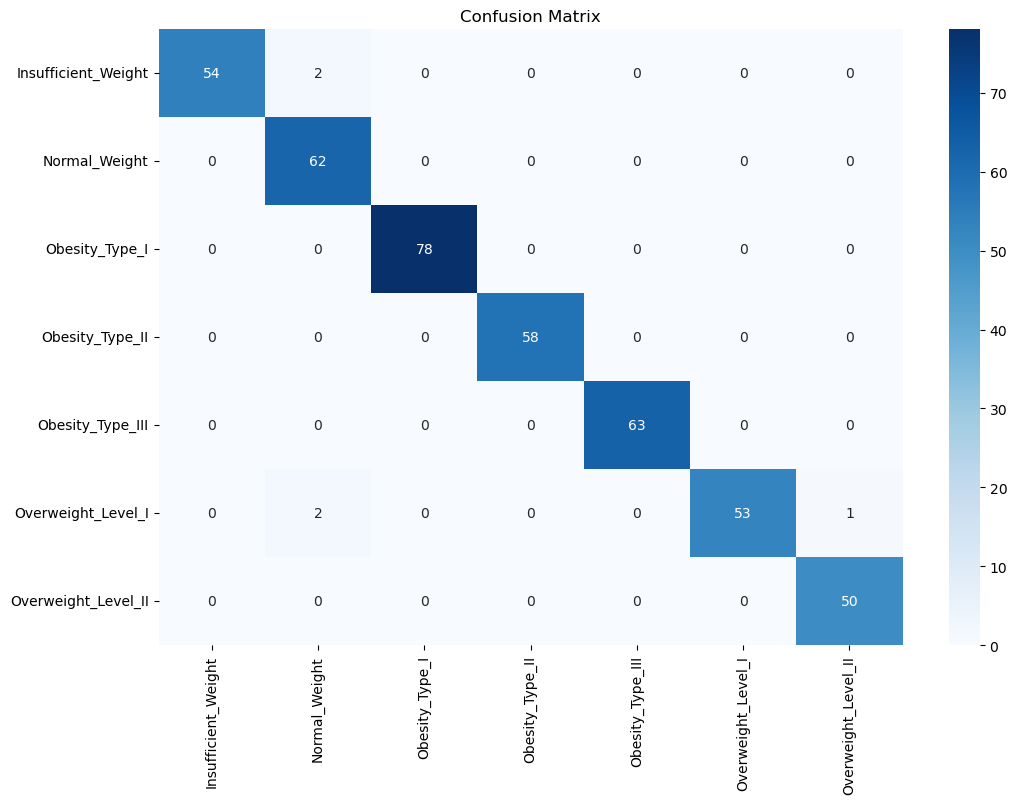

In [20]:

# Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', 
            cmap='Blues', xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.title('Confusion Matrix')
plt.show()

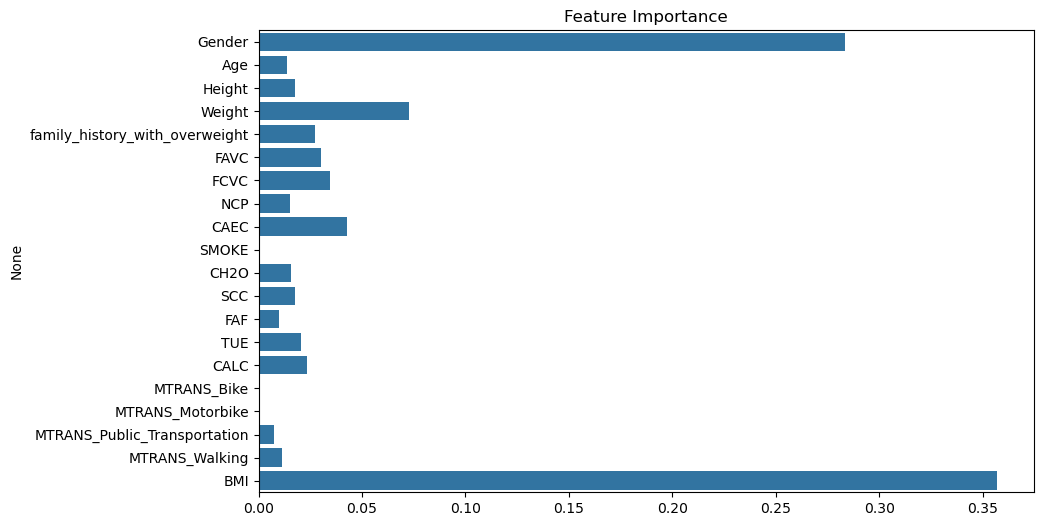

In [22]:
# Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=best_model.feature_importances_, y=X.columns)
plt.title('Feature Importance')
plt.show()

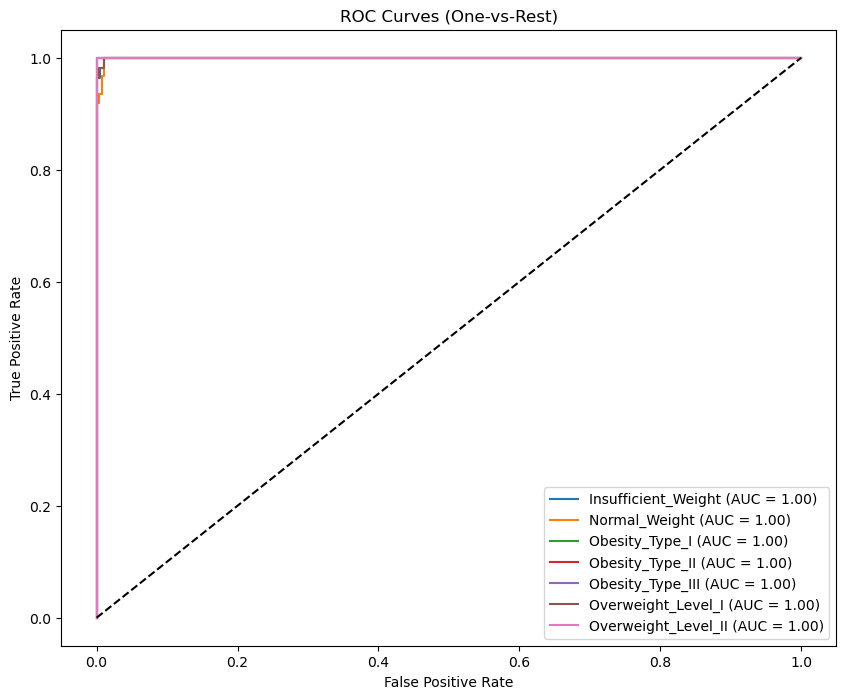

In [26]:
#ROC-AUC Curves (One-vs-Rest)
y_probs = best_model.predict_proba(X_test)
n_classes = len(le_y.classes_)

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_probs[:, i])
    plt.plot(fpr, tpr, label=f'{le_y.classes_[i]} (AUC = {roc_auc_score(y_test == i, y_probs[:, i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend()
plt.show()


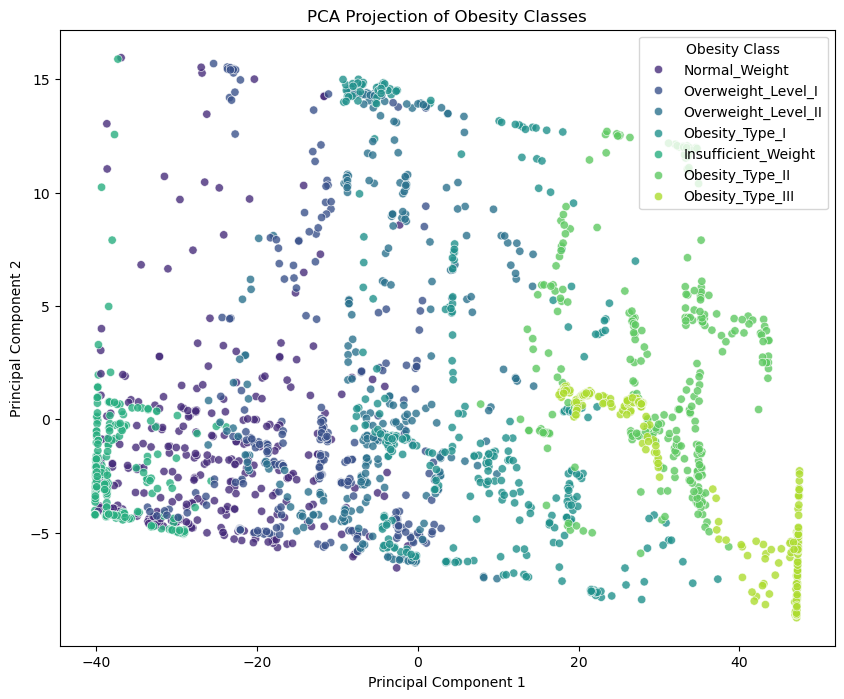

In [28]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=le_y.inverse_transform(y), 
                palette='viridis', alpha=0.8)
plt.title('PCA Projection of Obesity Classes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Obesity Class')
plt.show()